## Additional Results DeepSeek

In [ ]:
import os
import re
import pandas as pd
import json


def match_model_name(filename):
    if "Qwen2.5-1.5B-Instruct" in filename:
        model_name = "Qwen2.5-1.5B-Instruct"
    elif "Phi-3.5-mini-instruct" in filename:
        model_name = "Phi-3.5-mini-instruct"
    elif "Llama-3.2-3B-Instruct" in filename:
        model_name = "Llama-3.2-3B-Instruct"
    elif "Qwen2.5-3B-Instruct" in filename:
        model_name = "Qwen2.5-3B-Instruct"
    elif "Llama-3.2-1B-Instruct" in filename:
        model_name = "Llama-3.2-1B-Instruct"
    elif "Llama-2-7b-chat-hf" in filename:
        model_name = "Llama-2-7b-chat-hf"
    elif "Llama-2-13b-chat-hf" in filename:
        model_name = "Llama-2-13b-chat-hf"
    elif "Llama-2-70b-chat-hf" in filename:
        model_name = "Llama-2-70b-chat-hf"
    elif "Meta-Llama-3-8B-Instruct" in filename:
        model_name = "Meta-Llama-3-8B-Instruct"
    elif "Meta-Llama-3-70B-Instruct" in filename:
        model_name = "Meta-Llama-3-70B-Instruct"
    elif "Mistral-7B-Instruct-v0.2" in filename:
        model_name = "Mistral-7B-Instruct-v0.2"
    elif "Mixtral-8x7B-Instruct-v0.1" in filename:
        model_name = "Mixtral-8x7B-Instruct-v0.1"
    elif "DeepSeek-R1-Distill-Llama-70B" in filename:
        model_name = "DeepSeek-R1-Distill-Llama-70B"
    elif "DeepSeek-R1-Distill-Qwen-1.5B" in filename:
        model_name = "DeepSeek-R1-Distill-Qwen-1.5B"
    elif "Llama-3.1-8B-Instruct" in filename:
        model_name = "Llama-3.1-8B-Instruct"
    else:
        raise ValueError(f"Unknown model name in filename: {filename}")
    return model_name


folder_path = "/home/snt/projects_lujun/temperature_eval_github/temperature_eval/data/Additional_Results/evaluation_topkp_sampling"

dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".jsonl"):
        file_path = os.path.join(folder_path, filename)

        with open(file_path, "r") as file:
            print(filename)
            records = []
            for line in file:
                line = line.strip()
                if not line:
                    continue
                try:
                    record = json.loads(line)
                    records.append(record)
                except json.JSONDecodeError as e:
                    print(f"[WARNING] Skipping bad line in {filename}: {e}")
            df = pd.DataFrame(records)
            df["model_name"] = match_model_name(filename)
            df["file_path"] = filename
            if "accuracy" in df.columns:
                df["accuracy"] = df["accuracy"].astype(float)
            else:
                df["accuracy"] = df.apply(
                    lambda row: (
                        row[f"{row['category']}_accuracy"]
                        if f"{row['category']}_accuracy" in df.columns
                        else None
                    ),
                    axis=1,
                )
            df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")
            df["temperature"] = df["temperature"].apply(
                lambda x: round(x, 2) if pd.notna(x) else x
            )
            columns_to_keep = [
                "model_name",
                "file_path",
                "temperature",
                "category",
                "accuracy",
            ]
            df = df[columns_to_keep]
            dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
# df = df.dropna(subset=["accuracy"])

In [2]:
import pandas as pd
import re


def parse_model_name(name):
    name = name.replace("evaluated_", "")
    parts = name.split("__")
    if len(parts) < 2:
        return None
    model_info = parts[0]
    params = parts[1]
    r_match = re.search(r"r_([0-9.]+)", params)
    p_match = re.search(r"p_([0-9.]+)", params)
    k_match = re.search(r"k_([0-9]+)", params)
    r = float(r_match.group(1)) if r_match else None
    p = float(p_match.group(1)) if p_match else None
    k = int(k_match.group(1)) if k_match else None

    models = model_info.split("_vllm_exp_dataset_csv_")
    if len(models) < 2:
        return None
    evaluated_model = models[0]
    tested_model = models[1]
    return {
        "evaluated_model": evaluated_model,
        "tested_model": tested_model,
        "repetition_penalty": r,
        "top_p": p,
        "top_k": k,
    }


parsed_data = df["file_path"].apply(parse_model_name)
parsed_df = pd.DataFrame(parsed_data.tolist())
df = pd.concat([df, parsed_df], axis=1)

In [4]:
print(df.top_p.value_counts())
print(df.repetition_penalty.value_counts())
print(df.top_k.value_counts())

# df[df["tested_model"] == "Llama-3.1-8B-Instruct-awq"].groupby(
#     ["tested_model", "top_p", "repetition_penalty", "top_k"]
# ).count()

# df[df["tested_model"] == "Llama-3.2-1B-Instruct-awq"].groupby(["tested_model", "top_p", "repetition_penalty", "top_k"]).count()

# df[df["tested_model"] == "Mixtral-8x7B-Instruct-v0.1-awq"].groupby(
#     ["tested_model", "top_p", "repetition_penalty", "top_k"]
# ).count()

df.groupby(["tested_model", "top_p", "repetition_penalty", "top_k", "category"])
df.loc[df["category"] == "MT", "accuracy"] = (
    df.loc[df["category"] == "MT", "accuracy"] / 100
)

top_p
0.8    290758
1.0    286545
0.9    285303
Name: count, dtype: int64
repetition_penalty
1.0    289182
2.0    288740
0.0    284684
Name: count, dtype: int64
top_k
2     294090
10    285254
5     283262
Name: count, dtype: int64


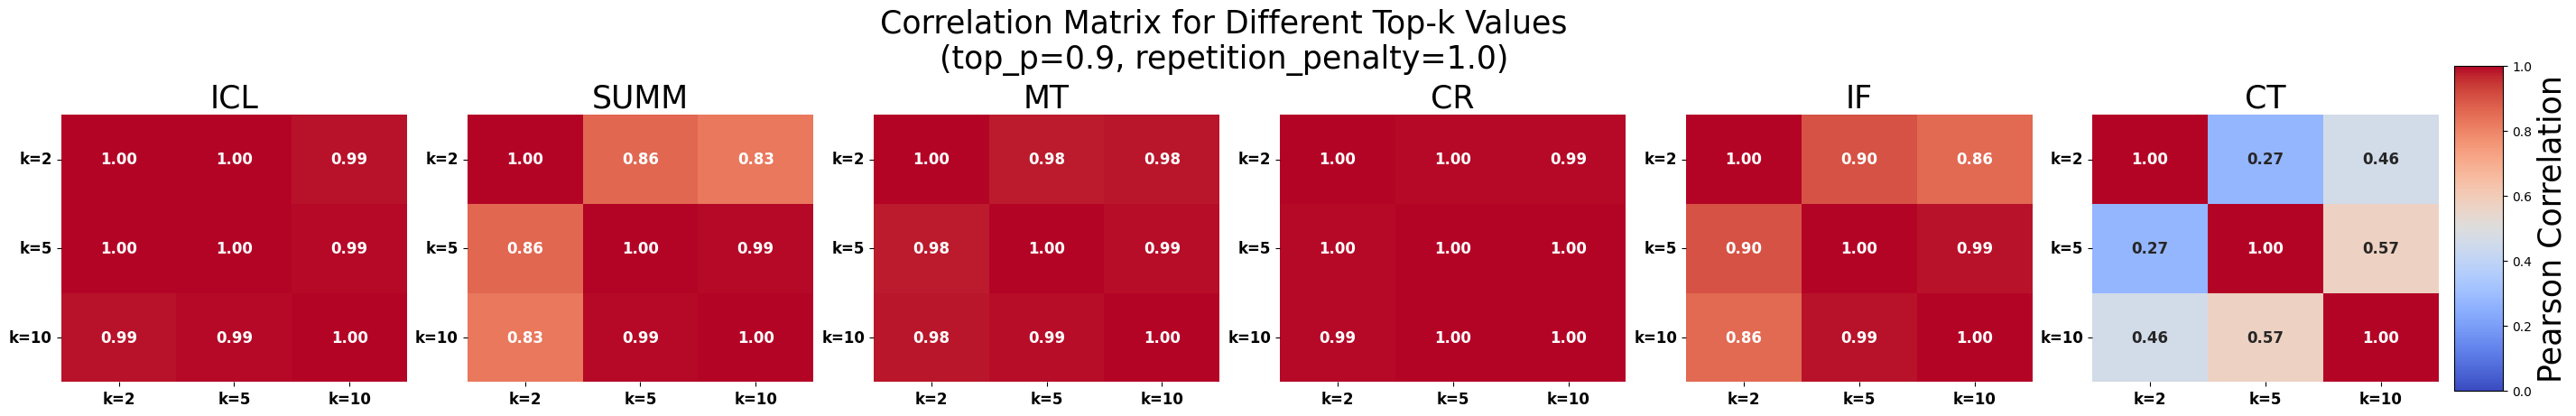

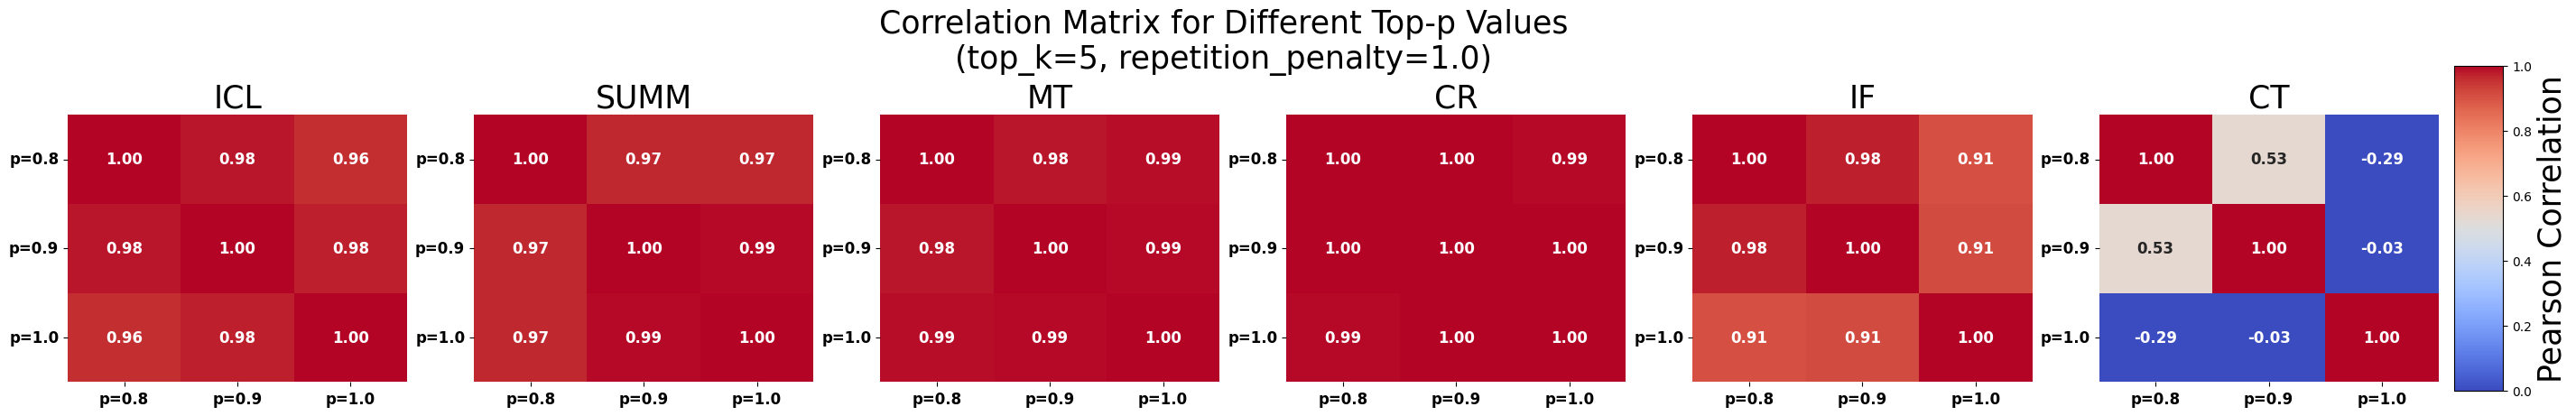

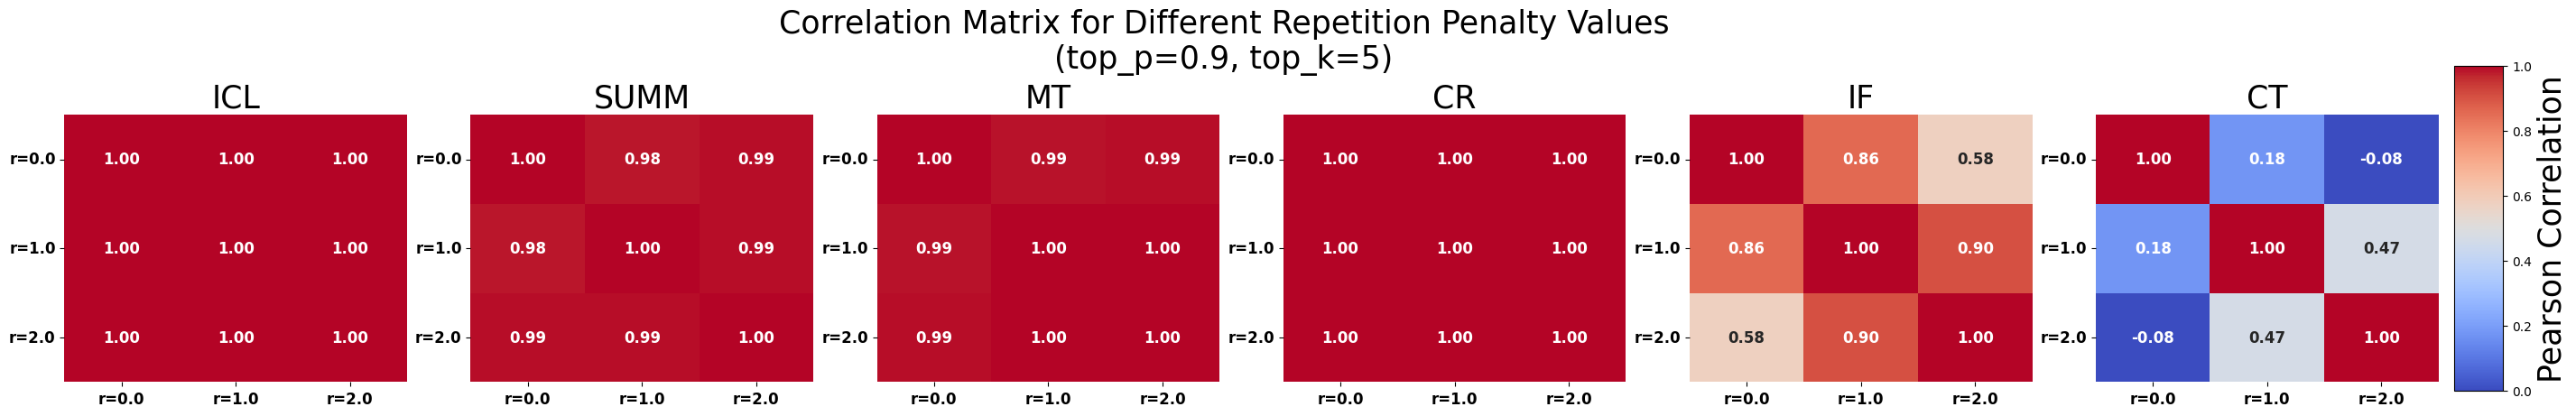

In [43]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product


def compute_flexible_correlation(df, top_p_list, repetition_penalty_list, top_k_list):
    categories = df["category"].unique()
    result = {}

    # 生成所有组合 (top_p, repetition_penalty, top_k)
    combos = list(product(top_p_list, repetition_penalty_list, top_k_list))
    if len(top_p_list) > 1:
        combo_labels = [f"p={p}" for p, rp, k in combos]
    elif len(repetition_penalty_list) > 1:
        combo_labels = [f"r={rp}" for p, rp, k in combos]
    elif len(top_k_list) > 1:
        combo_labels = [f"k={k}" for p, rp, k in combos]

    for category in categories:
        df_cat = df[df["category"] == category]

        # 为每个组合存储 accuracy 曲线
        curves = {}
        for (top_p, rp, top_k), label in zip(combos, combo_labels):
            df_sub = df_cat[
                (df_cat["top_p"] == top_p)
                & (df_cat["repetition_penalty"] == rp)
                & (df_cat["top_k"] == top_k)
            ]
            grouped = df_sub.groupby("temperature")["accuracy"].mean().reset_index()
            curves[label] = grouped.sort_values("temperature")

        # 找到所有组合共同的 temperature 点
        common_temps = set.intersection(
            *[set(c["temperature"]) for c in curves.values()]
        )
        common_temps = sorted(list(common_temps))

        # 抽取所有组合在共同温度点下的 accuracy
        acc_values = {}
        for label in combo_labels:
            df_curve = curves[label]
            df_curve = df_curve[df_curve["temperature"].isin(common_temps)]
            acc_values[label] = df_curve["accuracy"].values

        # 构造相关系数矩阵
        corr_matrix = pd.DataFrame(
            index=combo_labels, columns=combo_labels, dtype=float
        )
        for i in combo_labels:
            for j in combo_labels:
                if i == j:
                    corr_matrix.loc[i, j] = 1.0
                else:
                    r, _ = pearsonr(acc_values[i], acc_values[j])
                    corr_matrix.loc[i, j] = r

        result[category] = corr_matrix

    return result


def plot_correlation_heatmaps_row(
    corrs, vmin=0.0, vmax=1.0, cmap="coolwarm", annot=False, title="", setting_desc=""
):
    num_cats = len(corrs)
    ncols = 6
    nrows = (num_cats + ncols - 1) // ncols

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4.5 * ncols, 4.5 * nrows),
        constrained_layout=True,
    )

    # Make sure axes is 2D array
    if nrows == 1:
        axes = np.array([axes])
    axes = axes.reshape((nrows, ncols))

    for (cat, corr_mat), ax in zip(corrs.items(), axes.flat):
        sns.heatmap(
            corr_mat.astype(float),
            annot=annot,
            fmt=".2f",
            annot_kws={"size": 12, "weight": "bold"},
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            ax=ax,
            cbar=False,
            xticklabels=True,
            yticklabels=True,
        )
        ax.set_title(f"{cat}", fontsize=25)
        ax.tick_params(axis="x", rotation=0)
        ax.tick_params(axis="y", rotation=90)
        ax.set_xticklabels(
            ax.get_xticklabels(), rotation=0, fontsize=12, fontweight="bold"
        )
        ax.set_yticklabels(
            ax.get_yticklabels(), rotation=0, fontsize=12, fontweight="bold"
        )

    # Hide unused subplots
    for idx in range(len(corrs), nrows * ncols):
        fig.delaxes(axes.flat[idx])

    # Add shared colorbar
    cbar_ax = fig.add_axes([1.005, 0.05, 0.02, 0.8])
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label("Pearson Correlation", fontsize=25)

    # Add super title with description
    plt.suptitle(f"{title}\n{setting_desc}", fontsize=25)
    plt.show()


top_p_list = [0.9]
repetition_penalty_list = [1.0]
top_k_list = [2, 5, 10]

corrs_all = compute_flexible_correlation(
    df,
    top_p_list=top_p_list,
    repetition_penalty_list=repetition_penalty_list,
    top_k_list=top_k_list,
)

plot_correlation_heatmaps_row(
    corrs_all,
    annot=True,
    title="Correlation Matrix for Different Top-k Values",
    setting_desc="(top_p=0.9, repetition_penalty=1.0)",
)

top_p_list = [0.8, 0.9, 1.0]
repetition_penalty_list = [1.0]
top_k_list = [5]

corrs_all = compute_flexible_correlation(
    df,
    top_p_list=top_p_list,
    repetition_penalty_list=repetition_penalty_list,
    top_k_list=top_k_list,
)

plot_correlation_heatmaps_row(
    corrs_all,
    annot=True,
    title="Correlation Matrix for Different Top-p Values",
    setting_desc="(top_k=5, repetition_penalty=1.0)",
)

top_p_list = [0.9]
repetition_penalty_list = [0.0, 1.0, 2.0]
top_k_list = [5]

corrs_all = compute_flexible_correlation(
    df,
    top_p_list=top_p_list,
    repetition_penalty_list=repetition_penalty_list,
    top_k_list=top_k_list,
)

plot_correlation_heatmaps_row(
    corrs_all,
    annot=True,
    title="Correlation Matrix for Different Repetition Penalty Values",
    setting_desc="(top_p=0.9, top_k=5)",
)

Category: ICL
          2         5         10
2   1.000000  0.996553  0.987523
5   0.996553  1.000000  0.993318
10  0.987523  0.993318  1.000000

Category: SUMM
          2         5         10
2   1.000000  0.861263  0.825496
5   0.861263  1.000000  0.993746
10  0.825496  0.993746  1.000000

Category: MT
          2         5         10
2   1.000000  0.979757  0.983457
5   0.979757  1.000000  0.990800
10  0.983457  0.990800  1.000000

Category: CR
          2         5         10
2   1.000000  0.995642  0.993388
5   0.995642  1.000000  0.999540
10  0.993388  0.999540  1.000000

Category: IF
          2         5         10
2   1.000000  0.899039  0.858366
5   0.899039  1.000000  0.987513
10  0.858366  0.987513  1.000000

Category: CT
          2         5         10
2   1.000000  0.269765  0.459613
5   0.269765  1.000000  0.572483
10  0.459613  0.572483  1.000000



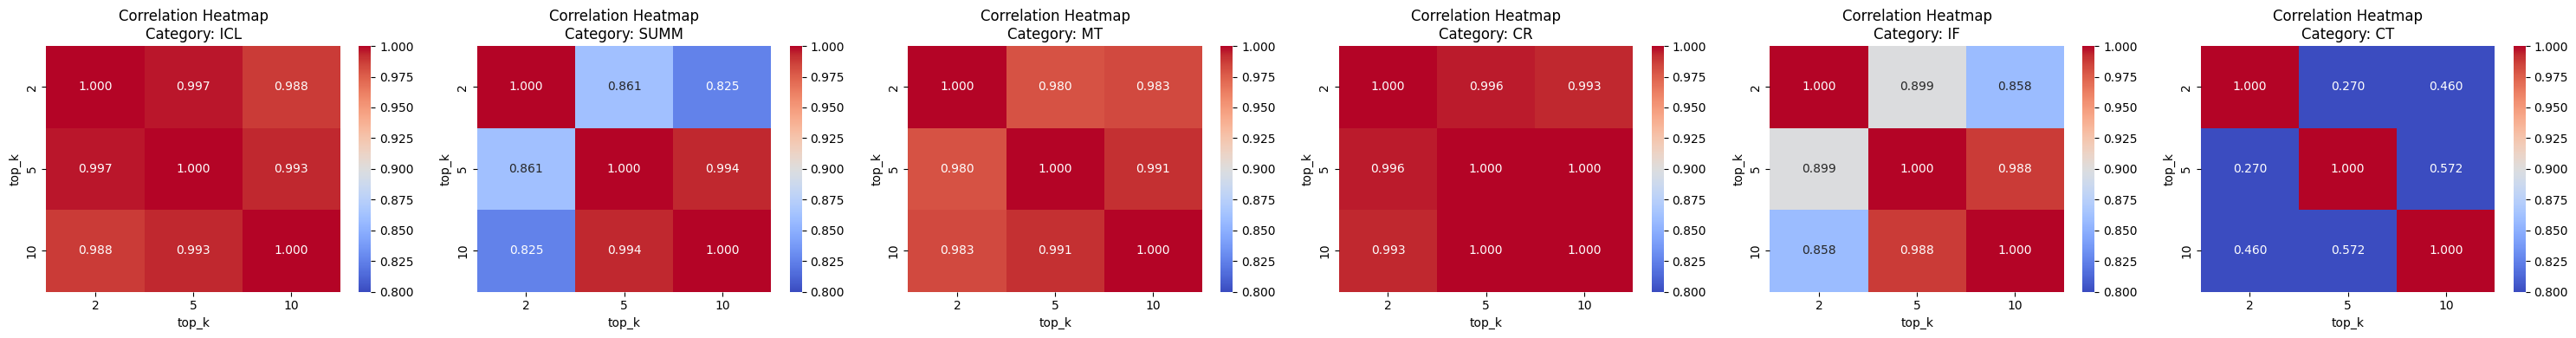

In [23]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr


def compute_topk_correlation(
    df, top_p=0.9, repetition_penalty=1.0, top_k_values=[2, 5, 10]
):
    categories = df["category"].unique()
    result = {}

    for category in categories:
        df_sub = df[
            (df["category"] == category)
            & (df["top_p"] == top_p)
            & (df["repetition_penalty"] == repetition_penalty)
        ]

        # 存储每个 top_k 的 (temperature, mean_accuracy)
        curves = {}
        for top_k in top_k_values:
            df_k = df_sub[df_sub["top_k"] == top_k]
            grouped = df_k.groupby("temperature")["accuracy"].mean().reset_index()
            curves[top_k] = grouped.sort_values("temperature")

        # 对齐所有曲线的 temperature，方便计算相关系数
        # 找到所有曲线共有的温度点
        common_temps = set(curves[top_k_values[0]]["temperature"])
        for tk in top_k_values[1:]:
            common_temps = common_temps.intersection(set(curves[tk]["temperature"]))
        common_temps = sorted(list(common_temps))

        # 根据共同温度点抽取对应 accuracy 值
        acc_values = {}
        for tk in top_k_values:
            df_curve = curves[tk]
            df_curve = df_curve[df_curve["temperature"].isin(common_temps)]
            acc_values[tk] = df_curve["accuracy"].values

        # 计算相关系数矩阵
        corr_matrix = pd.DataFrame(
            index=top_k_values, columns=top_k_values, dtype=float
        )
        for i in top_k_values:
            for j in top_k_values:
                if i == j:
                    corr_matrix.loc[i, j] = 1.0
                else:
                    r, _ = pearsonr(acc_values[i], acc_values[j])
                    corr_matrix.loc[i, j] = r

        result[category] = corr_matrix

    return result


# 用法示例
corrs = compute_topk_correlation(df)
for cat, corr_mat in corrs.items():
    print(f"Category: {cat}")
    print(corr_mat)
    print()


import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation_heatmaps(corrs):
    num_cats = len(corrs)
    fig, axes = plt.subplots(1, num_cats, figsize=(5 * num_cats, 4))
    if num_cats == 1:
        axes = [axes]
    for ax, (cat, corr_mat) in zip(axes, corrs.items()):
        sns.heatmap(
            corr_mat.astype(float),
            annot=True,
            fmt=".3f",
            cmap="coolwarm",
            vmin=0.8,
            vmax=1.0,
            ax=ax,
        )
        ax.set_title(f"Correlation Heatmap\nCategory: {cat}")
        ax.set_xlabel("top_k")
        ax.set_ylabel("top_k")
    plt.tight_layout()
    plt.show()


# 调用绘图函数，绘制你已经计算好的相关系数矩阵
plot_correlation_heatmaps(corrs)

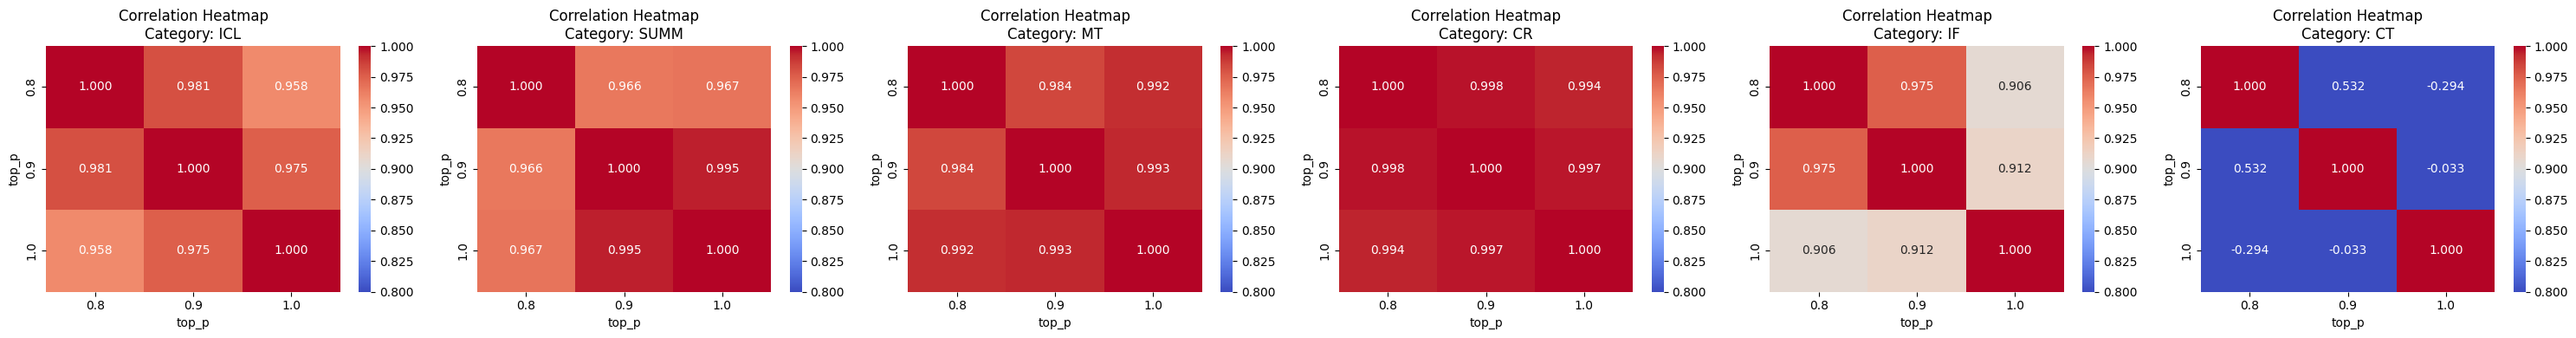

In [17]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns


def compute_topp_correlation(
    df, top_p_values=[0.7, 0.8, 0.9], repetition_penalty=1.0, top_k=5
):
    categories = df["category"].unique()
    result = {}

    for category in categories:
        df_sub = df[
            (df["category"] == category)
            & (df["repetition_penalty"] == repetition_penalty)
            & (df["top_k"] == top_k)
        ]

        # 存储每个 top_p 的 (temperature, mean_accuracy)
        curves = {}
        for top_p in top_p_values:
            df_p = df_sub[df_sub["top_p"] == top_p]
            grouped = df_p.groupby("temperature")["accuracy"].mean().reset_index()
            curves[top_p] = grouped.sort_values("temperature")

        # 找到所有曲线共有的温度点
        common_temps = set(curves[top_p_values[0]]["temperature"])
        for tp in top_p_values[1:]:
            common_temps = common_temps.intersection(set(curves[tp]["temperature"]))
        common_temps = sorted(list(common_temps))

        # 抽取共同温度点对应的准确率
        acc_values = {}
        for tp in top_p_values:
            df_curve = curves[tp]
            df_curve = df_curve[df_curve["temperature"].isin(common_temps)]
            acc_values[tp] = df_curve["accuracy"].values

        # 计算相关系数矩阵
        corr_matrix = pd.DataFrame(
            index=top_p_values, columns=top_p_values, dtype=float
        )
        for i in top_p_values:
            for j in top_p_values:
                if i == j:
                    corr_matrix.loc[i, j] = 1.0
                else:
                    r, _ = pearsonr(acc_values[i], acc_values[j])
                    corr_matrix.loc[i, j] = r

        result[category] = corr_matrix

    return result


def plot_correlation_heatmaps(corrs, xlabel="top_p", ylabel="top_p"):
    num_cats = len(corrs)
    fig, axes = plt.subplots(1, num_cats, figsize=(5 * num_cats, 4))
    if num_cats == 1:
        axes = [axes]
    for ax, (cat, corr_mat) in zip(axes, corrs.items()):
        sns.heatmap(
            corr_mat.astype(float),
            annot=True,
            fmt=".3f",
            cmap="coolwarm",
            vmin=0.8,
            vmax=1.0,
            ax=ax,
        )
        ax.set_title(f"Correlation Heatmap\nCategory: {cat}")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()


# 用法示例
top_p_values = [0.8, 0.9, 1.0]
corrs_p = compute_topp_correlation(df, top_p_values=top_p_values, top_k=5)
plot_correlation_heatmaps(corrs_p, xlabel="top_p", ylabel="top_p")

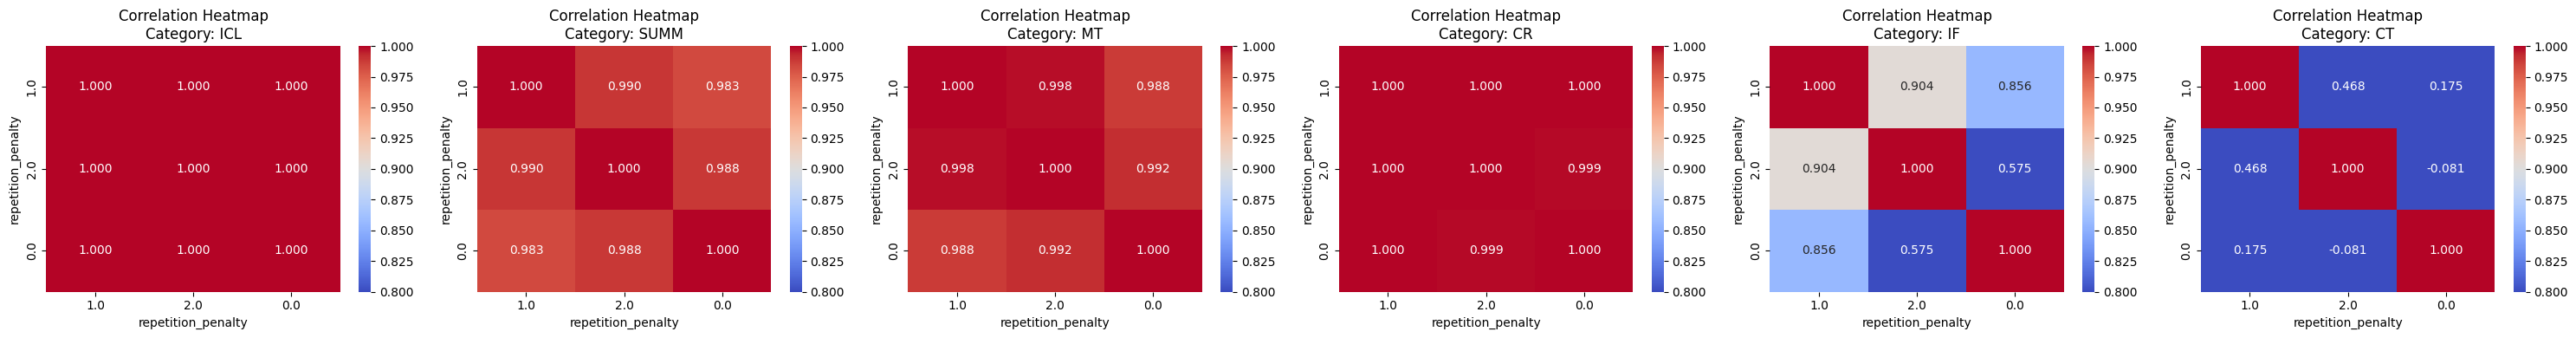

In [19]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns


def compute_repetition_penalty_correlation(
    df, repetition_penalty_values=[1.0, 1.1, 1.2], top_p=0.9, top_k=5
):
    categories = df["category"].unique()
    result = {}

    for category in categories:
        df_sub = df[
            (df["category"] == category)
            & (df["top_p"] == top_p)
            & (df["top_k"] == top_k)
        ]

        # 存储每个 repetition_penalty 的 (temperature, mean_accuracy)
        curves = {}
        for rp in repetition_penalty_values:
            df_rp = df_sub[df_sub["repetition_penalty"] == rp]
            grouped = df_rp.groupby("temperature")["accuracy"].mean().reset_index()
            curves[rp] = grouped.sort_values("temperature")

        # 找到所有曲线共有的温度点
        common_temps = set(curves[repetition_penalty_values[0]]["temperature"])
        for rp in repetition_penalty_values[1:]:
            common_temps = common_temps.intersection(set(curves[rp]["temperature"]))
        common_temps = sorted(list(common_temps))

        # 抽取共同温度点对应的准确率
        acc_values = {}
        for rp in repetition_penalty_values:
            df_curve = curves[rp]
            df_curve = df_curve[df_curve["temperature"].isin(common_temps)]
            acc_values[rp] = df_curve["accuracy"].values

        # 计算相关系数矩阵
        corr_matrix = pd.DataFrame(
            index=repetition_penalty_values,
            columns=repetition_penalty_values,
            dtype=float,
        )
        for i in repetition_penalty_values:
            for j in repetition_penalty_values:
                if i == j:
                    corr_matrix.loc[i, j] = 1.0
                else:
                    r, _ = pearsonr(acc_values[i], acc_values[j])
                    corr_matrix.loc[i, j] = r

        result[category] = corr_matrix

    return result


def plot_correlation_heatmaps(
    corrs, xlabel="repetition_penalty", ylabel="repetition_penalty"
):
    num_cats = len(corrs)
    fig, axes = plt.subplots(1, num_cats, figsize=(5 * num_cats, 4))
    if num_cats == 1:
        axes = [axes]
    for ax, (cat, corr_mat) in zip(axes, corrs.items()):
        sns.heatmap(
            corr_mat.astype(float),
            annot=True,
            fmt=".3f",
            cmap="coolwarm",
            vmin=0.8,
            vmax=1.0,
            ax=ax,
        )
        ax.set_title(f"Correlation Heatmap\nCategory: {cat}")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()


# 用法示例
repetition_penalty_values = [1.0, 2.0, 0.0]
corrs_rp = compute_repetition_penalty_correlation(
    df, repetition_penalty_values=repetition_penalty_values, top_p=0.9, top_k=5
)
plot_correlation_heatmaps(
    corrs_rp, xlabel="repetition_penalty", ylabel="repetition_penalty"
)

In [20]:
corrs_rp

{'ICL':           1.0       2.0       0.0
 1.0  1.000000  0.999916  0.999971
 2.0  0.999916  1.000000  0.999930
 0.0  0.999971  0.999930  1.000000,
 'SUMM':           1.0       2.0       0.0
 1.0  1.000000  0.989532  0.983274
 2.0  0.989532  1.000000  0.988496
 0.0  0.983274  0.988496  1.000000,
 'MT':           1.0       2.0      0.0
 1.0  1.000000  0.998073  0.98781
 2.0  0.998073  1.000000  0.99177
 0.0  0.987810  0.991770  1.00000,
 'CR':           1.0       2.0       0.0
 1.0  1.000000  0.999819  0.999568
 2.0  0.999819  1.000000  0.999134
 0.0  0.999568  0.999134  1.000000,
 'IF':           1.0       2.0       0.0
 1.0  1.000000  0.903875  0.855606
 2.0  0.903875  1.000000  0.575156
 0.0  0.855606  0.575156  1.000000,
 'CT':           1.0       2.0       0.0
 1.0  1.000000  0.468366  0.175104
 2.0  0.468366  1.000000 -0.081293
 0.0  0.175104 -0.081293  1.000000}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation_heatmaps(corrs):
    num_cats = len(corrs)
    fig, axes = plt.subplots(1, num_cats, figsize=(5 * num_cats, 4))
    if num_cats == 1:
        axes = [axes]
    for ax, (cat, corr_mat) in zip(axes, corrs.items()):
        sns.heatmap(
            corr_mat.astype(float),
            annot=True,
            fmt=".3f",
            cmap="coolwarm",
            vmin=0.8,
            vmax=1.0,
            ax=ax,
        )
        ax.set_title(f"Correlation Heatmap\nCategory: {cat}")
        ax.set_xlabel("top_k")
        ax.set_ylabel("top_k")
    plt.tight_layout()
    plt.show()


# 调用绘图函数，绘制你已经计算好的相关系数矩阵
plot_correlation_heatmaps(corrs)

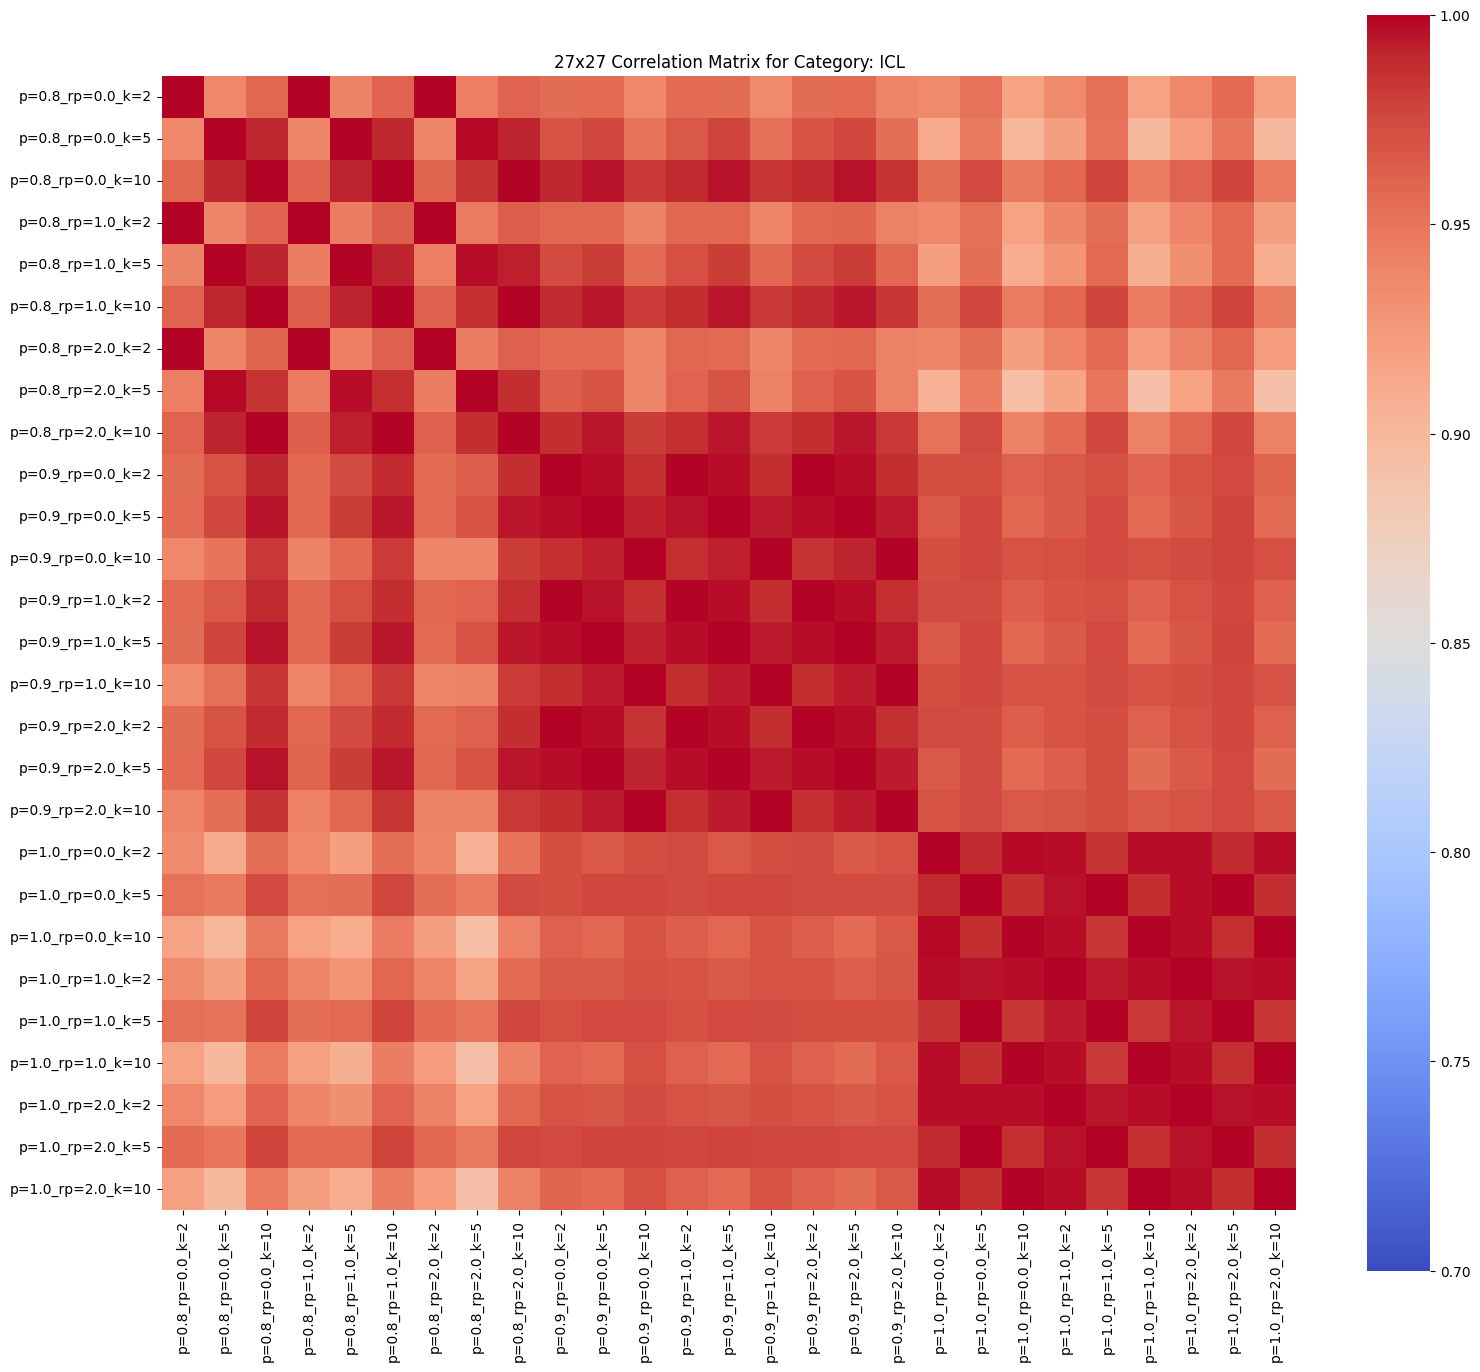

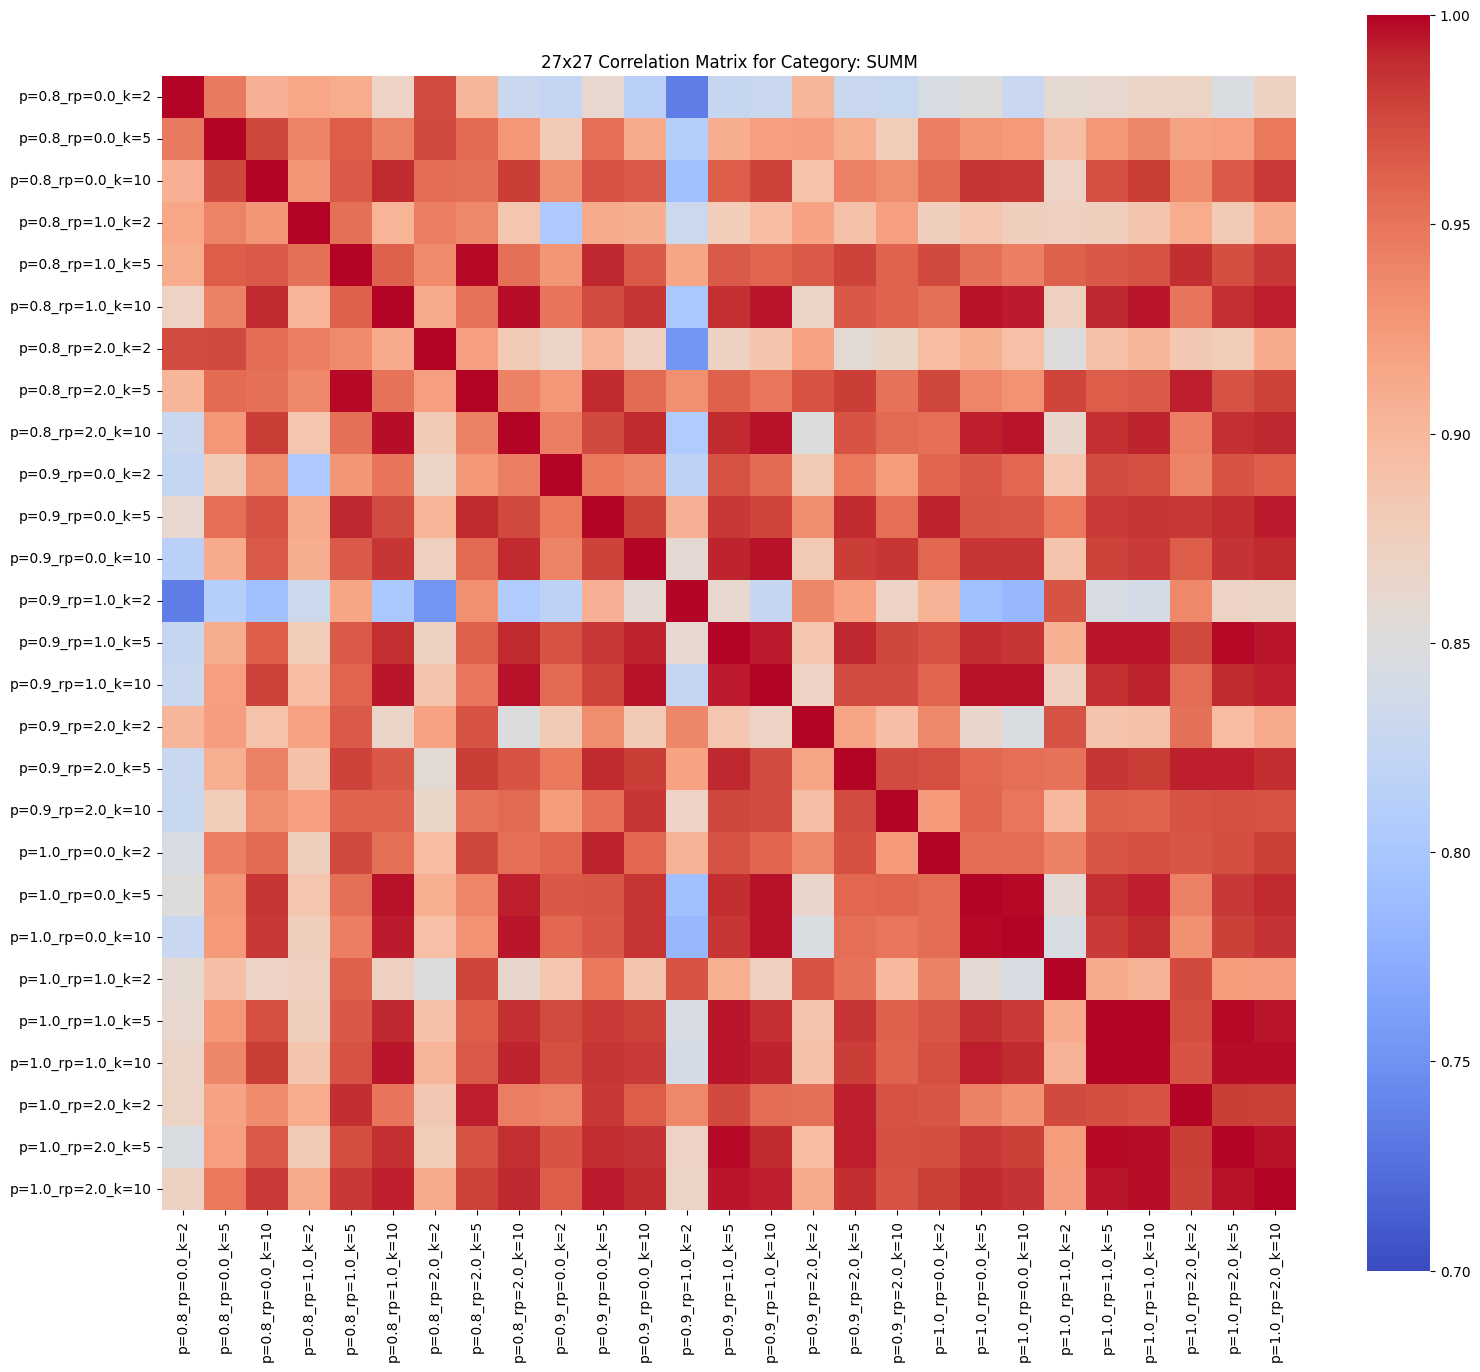

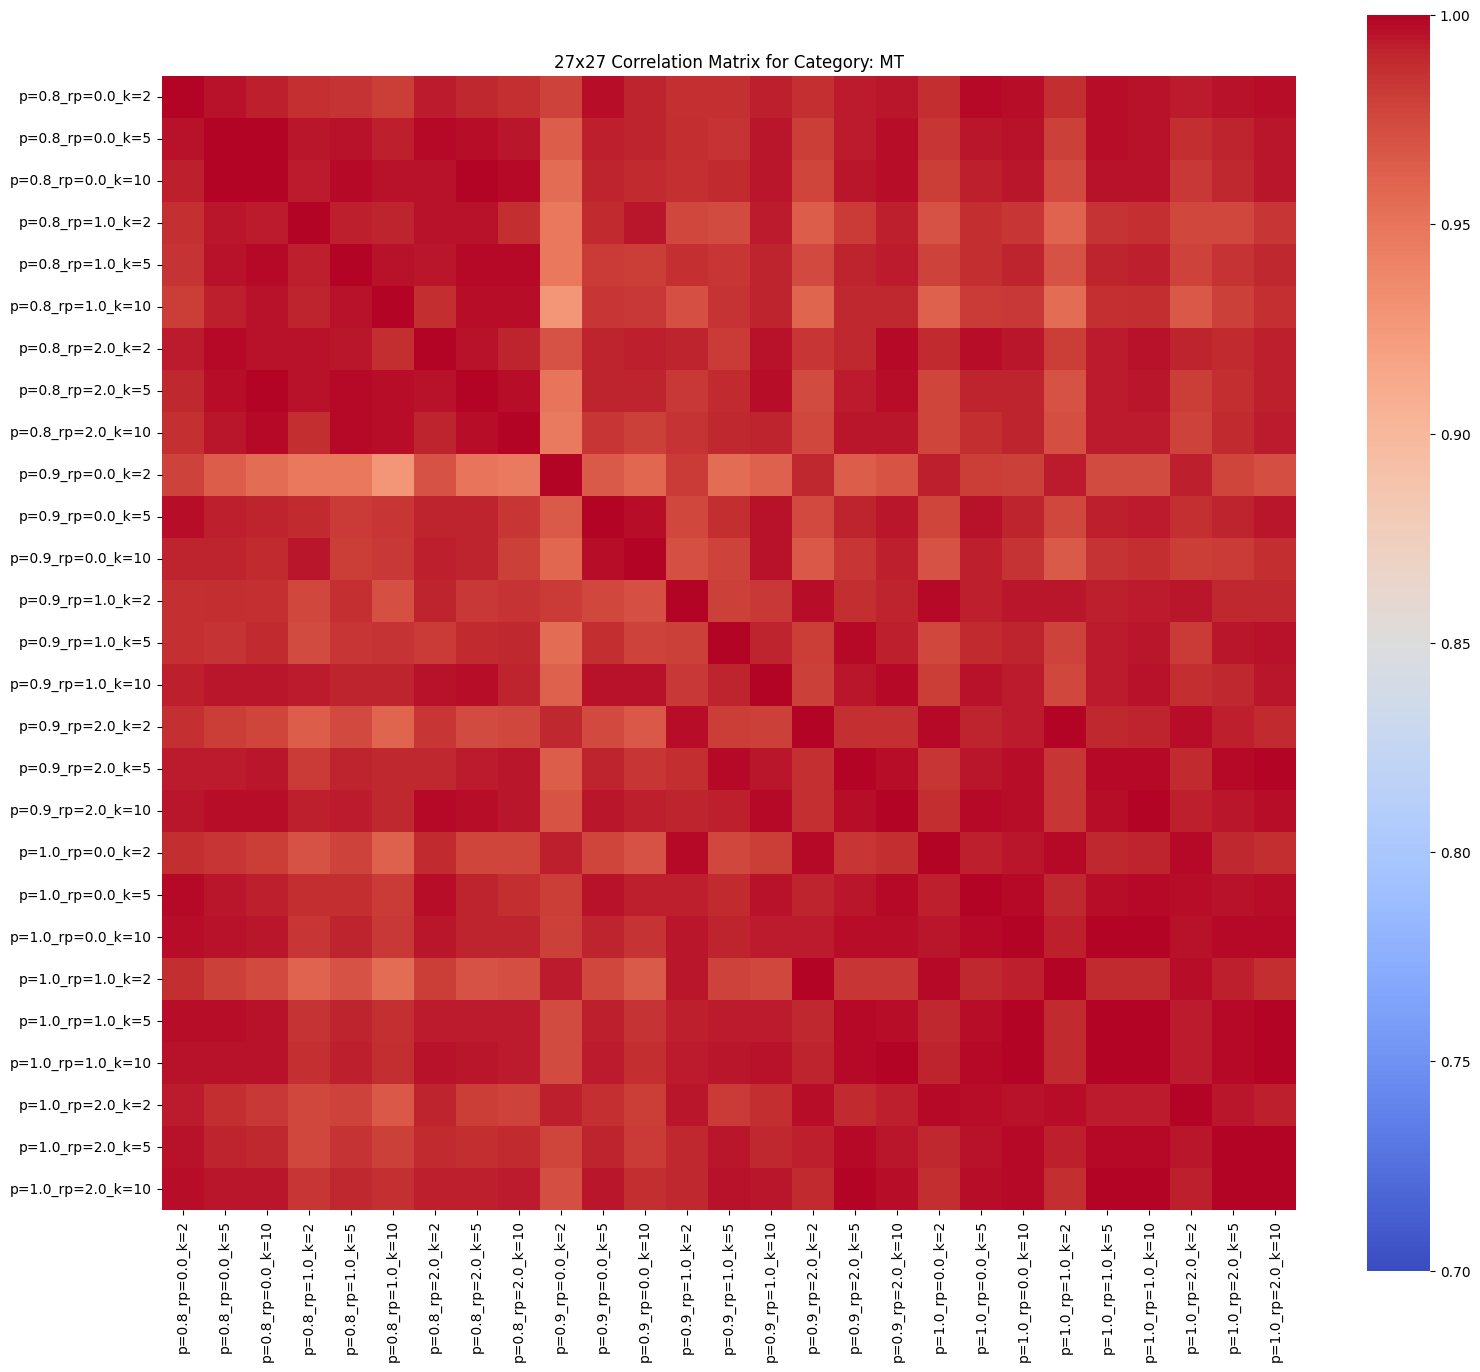

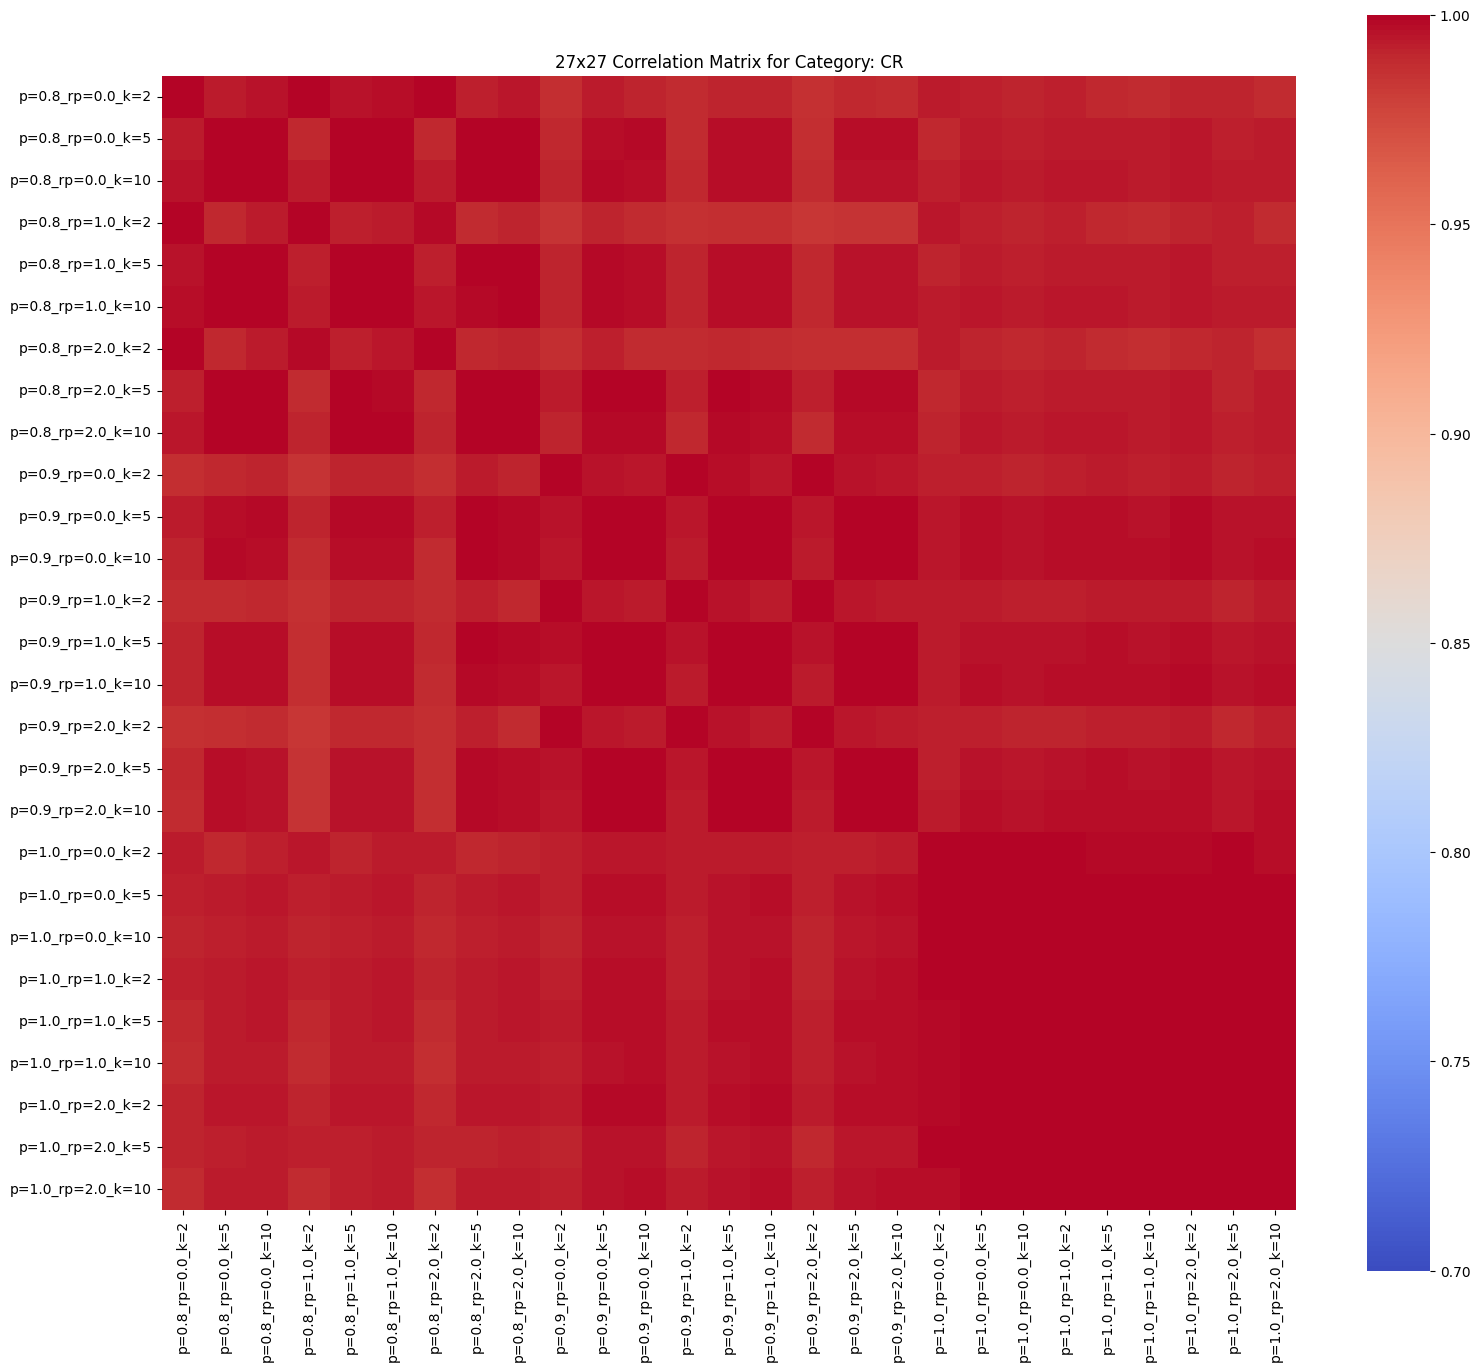

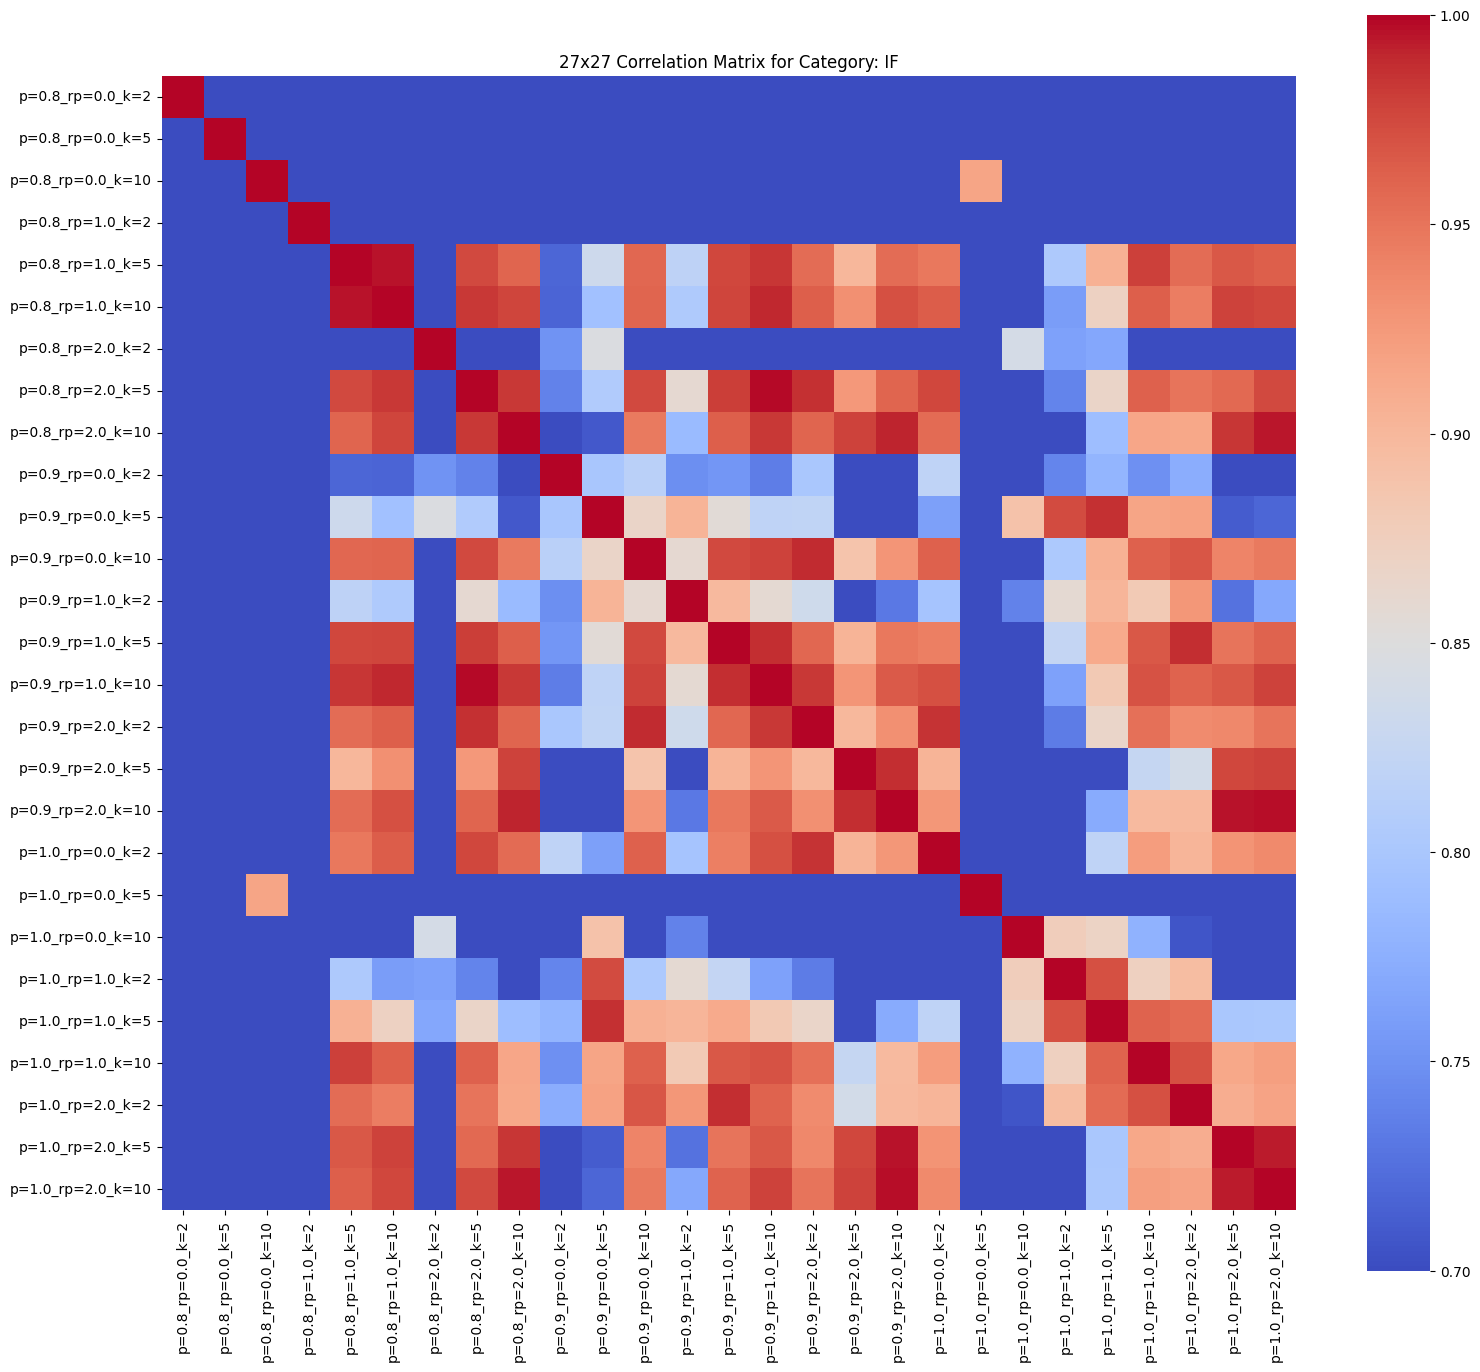

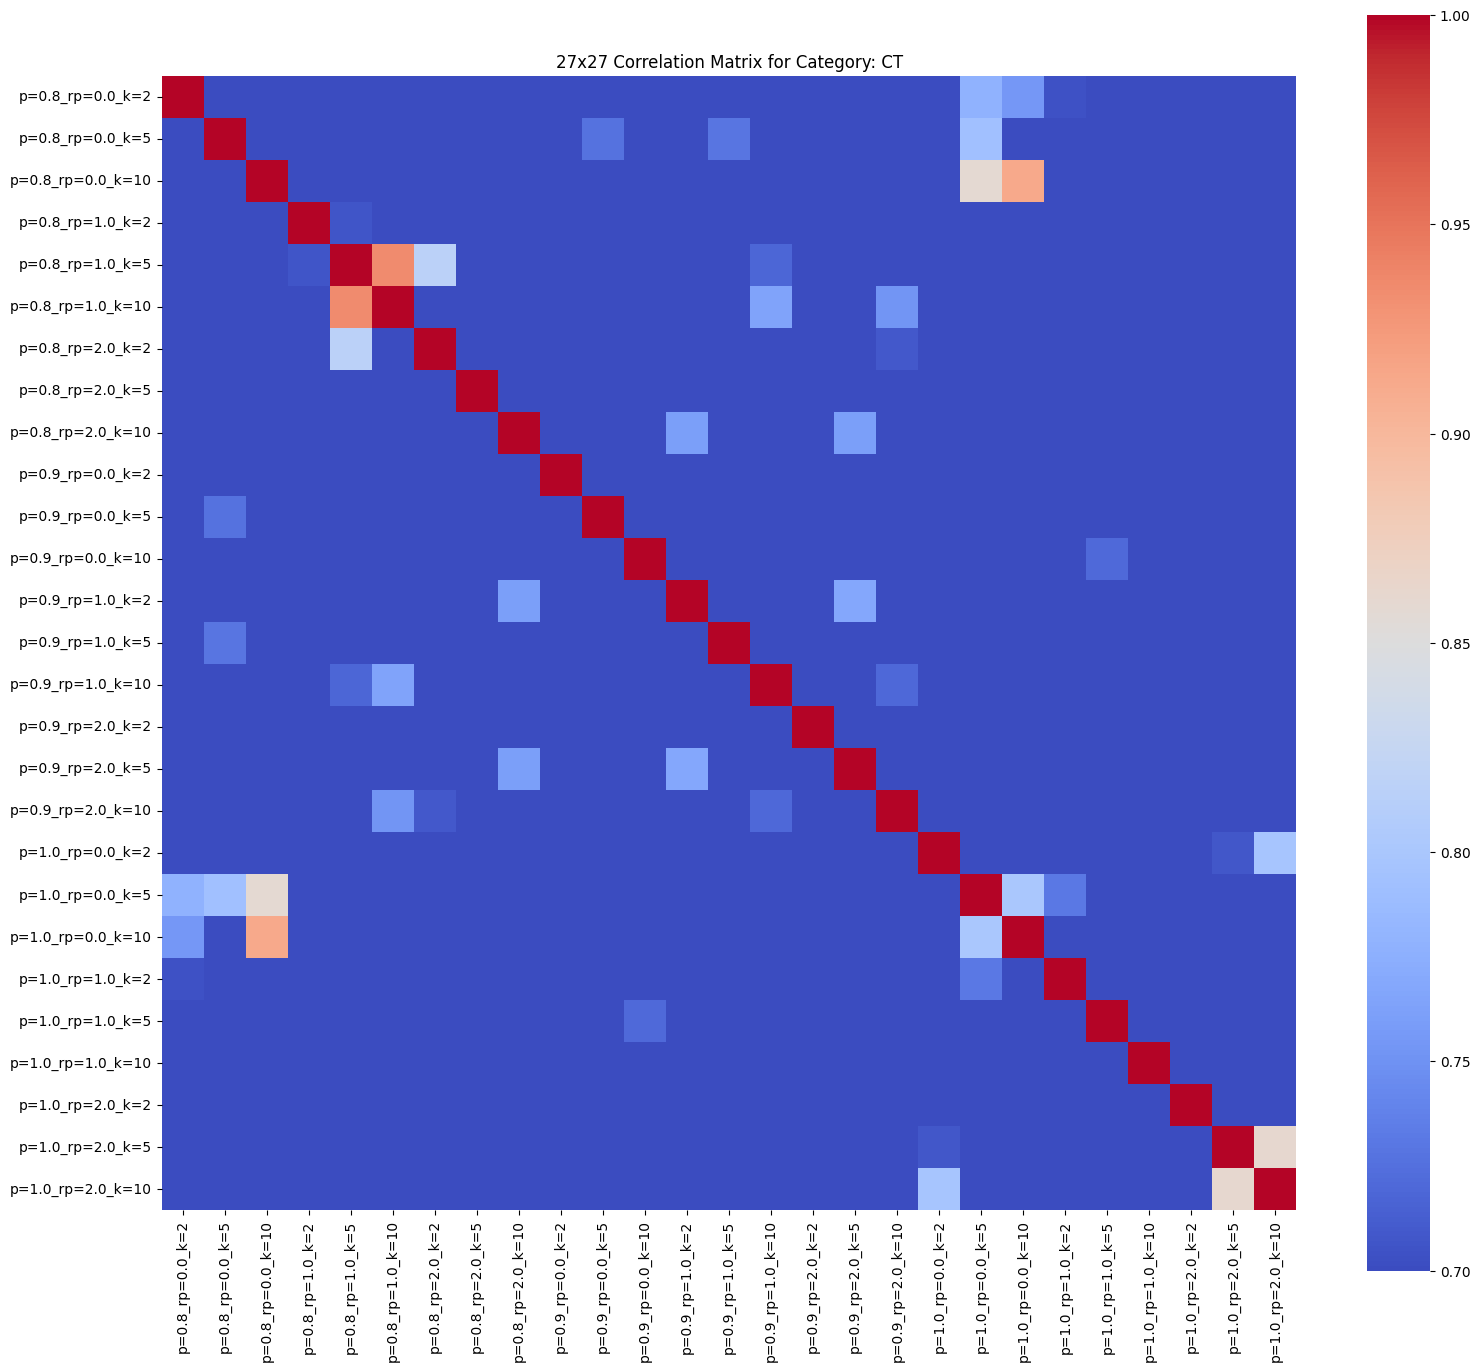

In [21]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product


def compute_all_combinations_correlation(df, top_p_values, rp_values, top_k_values):
    categories = df["category"].unique()
    result = {}

    # 构建所有组合的 key 列表
    combinations = list(product(top_p_values, rp_values, top_k_values))
    combo_labels = [f"p={p}_rp={rp}_k={k}" for p, rp, k in combinations]

    for category in categories:
        df_cat = df[df["category"] == category]

        curves = {}
        for (top_p, rp, top_k), label in zip(combinations, combo_labels):
            df_sub = df_cat[
                (df_cat["top_p"] == top_p)
                & (df_cat["repetition_penalty"] == rp)
                & (df_cat["top_k"] == top_k)
            ]
            grouped = df_sub.groupby("temperature")["accuracy"].mean().reset_index()
            curves[label] = grouped.sort_values("temperature")

        # 找到所有曲线共有的 temperature
        common_temps = set(curves[combo_labels[0]]["temperature"])
        for label in combo_labels[1:]:
            common_temps &= set(curves[label]["temperature"])
        common_temps = sorted(list(common_temps))

        acc_values = {}
        for label in combo_labels:
            df_curve = curves[label]
            df_curve = df_curve[df_curve["temperature"].isin(common_temps)]
            acc_values[label] = df_curve["accuracy"].values

        # 构建 27x27 的相关系数矩阵
        corr_matrix = pd.DataFrame(
            index=combo_labels, columns=combo_labels, dtype=float
        )
        for i in combo_labels:
            for j in combo_labels:
                if i == j:
                    corr_matrix.loc[i, j] = 1.0
                else:
                    r, _ = pearsonr(acc_values[i], acc_values[j])
                    corr_matrix.loc[i, j] = r

        result[category] = corr_matrix

    return result


def plot_large_correlation_matrix(corrs, figsize=(16, 14)):
    for cat, corr_mat in corrs.items():
        plt.figure(figsize=figsize)
        sns.heatmap(
            corr_mat.astype(float),
            annot=False,
            fmt=".2f",
            cmap="coolwarm",
            vmin=0.7,
            vmax=1.0,
            xticklabels=True,
            yticklabels=True,
            square=True,
        )
        plt.title(f"27x27 Correlation Matrix for Category: {cat}")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()


top_p_values = [0.8, 0.9, 1.0]
rp_values = [0.0, 1.0, 2.0]
top_k_values = [2, 5, 10]

corrs_all = compute_all_combinations_correlation(
    df, top_p_values, rp_values, top_k_values
)
plot_large_correlation_matrix(corrs_all)

In [22]:
corrs_all

{'ICL':                    p=0.8_rp=0.0_k=2  p=0.8_rp=0.0_k=5  p=0.8_rp=0.0_k=10  \
 p=0.8_rp=0.0_k=2           1.000000          0.937098           0.958340   
 p=0.8_rp=0.0_k=5           0.937098          1.000000           0.989704   
 p=0.8_rp=0.0_k=10          0.958340          0.989704           1.000000   
 p=0.8_rp=1.0_k=2           0.999922          0.939996           0.960790   
 p=0.8_rp=1.0_k=5           0.941157          0.999172           0.991327   
 p=0.8_rp=1.0_k=10          0.960834          0.990002           0.999929   
 p=0.8_rp=2.0_k=2           0.999943          0.938626           0.960047   
 p=0.8_rp=2.0_k=5           0.943383          0.998533           0.985475   
 p=0.8_rp=2.0_k=10          0.960200          0.991177           0.999849   
 p=0.9_rp=0.0_k=2           0.955303          0.969133           0.989877   
 p=0.9_rp=0.0_k=5           0.955511          0.976231           0.995592   
 p=0.9_rp=0.0_k=10          0.937825          0.950309           0.98

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

category = "IF"
top_p = 0.9
repetition_penalty = 1.0
top_k_values = [2, 5, 10]

fig = go.Figure()

marker_symbols = {2: "circle", 5: "square", 10: "diamond"}

df_sub = df[
    (df["category"] == category)
    & (df["top_p"] == top_p)
    & (df["repetition_penalty"] == repetition_penalty)
]
model_names = df_sub["model_name"].unique()
color_palette = px.colors.qualitative.Plotly  # Plotly 默认调色板
color_map = {
    model: color_palette[i % len(color_palette)] for i, model in enumerate(model_names)
}

for top_k in top_k_values:
    df_k = df_sub[df_sub["top_k"] == top_k]
    grouped = (
        df_k.groupby(["model_name", "temperature"])["accuracy"].mean().reset_index()
    )

    for model_name, group in grouped.groupby("model_name"):
        group_sorted = group.sort_values("temperature")
        fig.add_trace(
            go.Scatter(
                x=group_sorted["temperature"],
                y=group_sorted["accuracy"],
                mode="lines+markers",
                name=f"{model_name}, top_k={top_k}",
                marker_symbol=marker_symbols[top_k],
                marker=dict(color=color_map[model_name]),
                line=dict(color=color_map[model_name]),
            )
        )

fig.update_layout(
    title=f"Average Accuracy vs Temperature for category={category}, top_p={top_p}, repetition_penalty={repetition_penalty}",
    xaxis_title="Temperature",
    yaxis_title="Average Accuracy",
    legend_title="Model and Top-k",
    template="plotly_white",
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=30),
)

fig.show()

In [6]:
import plotly.graph_objects as go
from scipy.interpolate import griddata
import numpy as np

category = "MT"
top_k1 = 2  # 2, 5, 10
top_k2 = 5  # 2, 5, 10
top_k_3 = 10  # 2, 5, 10

top_p = 0.9  # 0.8,0.9,1.0
reopetition_penalty = 1.1  # 0.0, 1.0, 2.0

df_cat = df[df["category"] == category]

grid_x, grid_y = np.meshgrid(
    np.linspace(df_cat["temperature"].min(), df_cat["temperature"].max(), 30),
    np.linspace(df_cat["top_p"].min(), df_cat["top_p"].max(), 30),
)

grid_z = griddata(
    (df_cat["temperature"], df_cat["top_p"]),
    df_cat["accuracy"],
    (grid_x, grid_y),
    method="cubic",
)

fig = go.Figure(data=[go.Surface(z=grid_z, x=grid_x, y=grid_y, colorscale="Viridis")])

fig.update_layout(
    title=f"3D Surface Plot for {category}",
    scene=dict(
        xaxis_title="Temperature",
        yaxis_title="Top-p",
        zaxis_title="Accuracy",
    ),
    autosize=True,
    margin=dict(l=0, r=0, b=0, t=30),
)

fig.show()

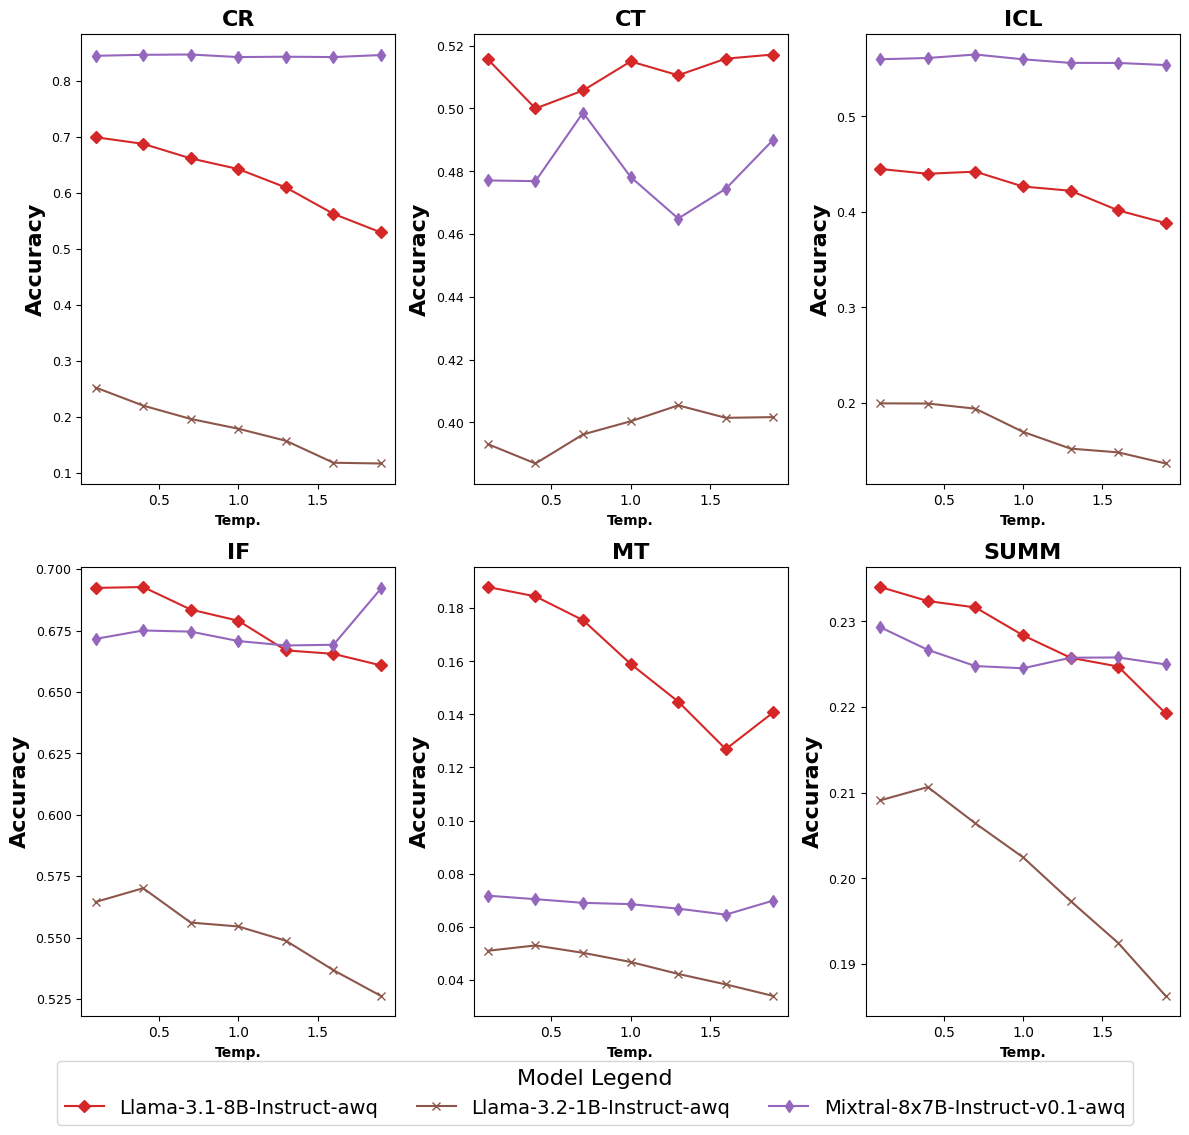

In [36]:
import matplotlib.pyplot as plt

color_map = {
    "Llama-2-7b-chat-hf": "C0",
    "Llama-2-13b-chat-hf": "C1",
    "Llama-2-70b-chat-hf": "C2",
    "Meta-Llama-3-8B-Instruct": "C3",
    "Meta-Llama-3-70B-Instruct": "C4",
    "Mistral-7B-Instruct-v0.2": "C5",
    "Mixtral-8x7B-Instruct-v0.1": "C6",
    "Llama-3.2-1B-Instruct": "C7",
    "Phi-3.5-mini-instruct": "C8",
    "Phi-3.5-mini-instruct": "C9",
    "Qwen2.5-1.5B-Instruct": "C10",
    "DeepSeek-R1-Distill-Llama-8B": "C11",
    "DeepSeek-R1-Distill-Qwen-7B": "C12",
    "Llama-3.1-8B-Instruct-awq": "C13",
    "Mixtral-8x7B-Instruct-v0.1-awq": "C14",
    "Llama-3.2-1B-Instruct-awq": "C15",
}
model_order = list(color_map.keys())

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]
model_marker_map = {model: markers[i] for i, model in enumerate(model_order)}


grouped = (
    df.groupby(["category", "tested_model", "temperature"])
    .accuracy.mean()
    .reset_index()
)

categories = grouped["category"].unique()

fig, axes = plt.subplots(2, 3, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.flatten()
added_labels = set()

for i, category in enumerate(categories[:6]):  # Adjust for a maximum of 6 categories
    ax = axes[i]
    subset = grouped[grouped["category"] == category]
    for model_name in subset["tested_model"].unique():
        model_data = subset[subset["tested_model"] == model_name]

        if model_name not in added_labels:
            ax.plot(
                model_data["temperature"],
                model_data["accuracy"],
                marker=model_marker_map[model_name],
                color=color_map[model_name],
                label=model_name,
            )
            added_labels.add(model_name)
        else:
            ax.plot(
                model_data["temperature"],
                model_data["accuracy"],
                marker=model_marker_map[model_name],
                color=color_map[model_name],
            )
    ax.set_title(category, fontsize=16, fontweight="bold")
    ax.set_xlabel("Temp.", fontsize=10, fontweight="bold")
    ax.set_ylabel("Accuracy", fontsize=16, fontweight="bold")
    ax.tick_params(axis="y", labelsize=9)

# Remove empty subplots if categories < 6
for j in range(len(categories), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and add shared legend
plt.tight_layout(rect=[0, 0.1, 1, 1])
fig.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=6,  # Adjust the number of columns in the legend to make it span the full width
    fontsize=14,  # Increase the font size of the legend
    title="Model Legend",
    title_fontsize=16,  # Increase the font size of the legend title
)

plt.savefig("temperature_eval_extend.svg")
plt.show()

In [37]:
import pandas as pd
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


param_cols = ["top_p", "temperature", "repetition_penalty", "top_k"]
X = df[param_cols]
y = df["accuracy"] / 100 if df["accuracy"].max() > 1 else df["accuracy"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. 拟合模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


# 4. 创建 SHAP explainer
explainer = shap.Explainer(model, X_train)

# 5. 计算 SHAP 值
shap_values = explainer(X_test)

shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)
shap.plots.scatter(shap_values[:, "temperature"], color=shap_values)
shap.plots.scatter(shap_values[:, "top_p"], color=shap_values)

/home/snt/miniconda3/envs/vllm_env_lujun/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

  4%|=                   | 6902/172522 [00:51<20:23]       

: 

: 